### Lung Disease Diagnosis Using Chest X-rays

In [71]:
# Importing All required packages
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
# Storing directory paths
cv19_dir = 'X-RayDataset/COVID19'
pn_dir = 'X-RayDataset/PNEUMONIA'
tb_dir = 'X-RayDataset/TURBERCULOSIS'
normal_dir = 'X-RayDataset/NORMAL'

# Storing Image sizes
img_width, img_height = 150, 150

In [57]:
# Function to load images
def load_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename) # getting individual img paths
        img = load_img(img_path, target_size=(img_height, img_width)) # imposing height and width
        img_array = img_to_array(img) # converting to an image array
        images.append(img_array) # adding image to images[]
        labels.append(label) # adding label to labels[]
    return images, labels

In [58]:
# Loading each directory (May need to reshape due to data imbalances)
cv19_images, cv19_labels = load_images(cv19_dir, 3) # 3 for covid
pn_images, pn_labels = load_images(pn_dir, 2) # 2 for pneumonia
tb_images, tb_labels = load_images(tb_dir, 1) # 1 for tb
normal_images, normal_labels = load_images(normal_dir, 0) # 0 for healthy


In [59]:
# Slicing to have only 500 images for each category (to prevent imbalances)
cv19_images, cv19_labels = cv19_images[:500], cv19_labels[:500]
pn_images, pn_labels = pn_images[:500], pn_labels[:500]
tb_images, tb_labels = tb_images[:500], tb_labels[:500]
normal_images, normal_labels = normal_images[:500], normal_labels[:500] 

# Making sure no errors
print(
    "Length of each array: ",
    len(cv19_images),
    len(cv19_labels),
    len(pn_images),
    len(pn_labels),
    len(tb_images),
    len(tb_labels),
    len(normal_images),
    len(normal_labels)
)

Length of each array:  500 500 500 500 500 500 500 500


In [60]:
# Combining all arrays into one array for images and labels
all_images = cv19_images + pn_images + tb_images + normal_images
all_labels = cv19_labels + pn_labels + tb_labels + normal_labels

In [61]:
# Converting to Tensorflow dataframe
all_images = tf.convert_to_tensor(all_images, dtype=tf.float32) / 255.0 # Normalize and convert
all_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)

In [62]:
# Displaying total length of images and labels array
print(f'Total amount of images: {len(all_images)}')
print(f'Total amount of labels: {len(all_labels)}')

Total amount of images: 2000
Total amount of labels: 2000


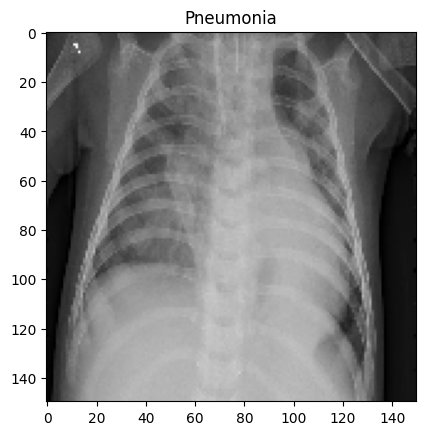

In [63]:
# Displaying a random image and its label (diagnosis)
index = 650

plt.imshow(all_images[index])
plt.title("Covid" if all_labels[index] == 3.0 else "Pneumonia" if all_labels[index] == 2.0 else "Tuberculosis" if all_labels[index] == 1.0 else "Healthy" )

plt.show()

In [64]:
# Shuffle the data:
indices = np.random.permutation(len(all_images))

shuffled_images = np.array(all_images)[indices]
shuffled_labels = np.array(all_labels)[indices]

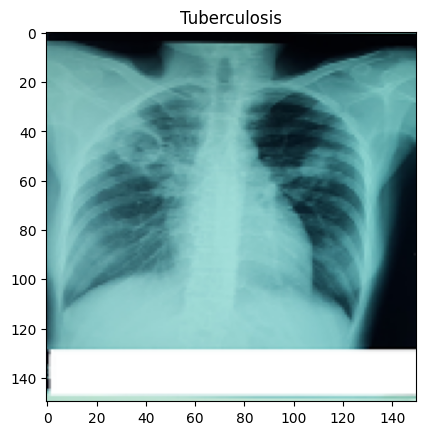

In [66]:
# Displaying a random image and its label (post-shuffle) 
index = 500

plt.imshow(shuffled_images[index])
plt.title("Covid" if shuffled_labels[index] == 3.0 else "Pneumonia" if shuffled_labels[index] == 2.0 else "Tuberculosis" if shuffled_labels[index] == 1.0 else "Healthy" )

plt.show()

In [67]:
# Splitting data into train, test, and validation

# Training set and remaining data ( will be validation + test data)
X_train, X_rem, y_train, y_rem = train_test_split(
    shuffled_images,
    shuffled_labels,
    test_size=0.3,  # 30% of the dataset goes to Validation + Test
    random_state=42,
)

# Second split: Validation and Test from the Remaining data
X_val, X_test, y_val, y_test = train_test_split(
    X_rem,
    y_rem,
    test_size=1/3,  # 1/3 of the remaining ()
    random_state=42,
)

# Printing sizes
print(f"Training set size: {len(X_train)} ({len(X_train)/len(shuffled_images)*100:.2f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(shuffled_images)*100:.2f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(shuffled_images)*100:.2f}%)")


Training set size: 1400 (70.00%)
Validation set size: 400 (20.00%)
Test set size: 200 (10.00%)


In [69]:
# Creating tensorflow datasets (train, val, and test)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffling/batching train dataset 
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=42).batch(32)

# Batching validation and test datsets
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [72]:
# Defining our model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),  # Helps with training stability and convergence
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),

    GlobalMaxPooling2D(),  # Reduces dimensions and helps prevent overfitting
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),  # L2 regularization to reduce overfitting
    Dropout(0.4),  # Regularization through dropout

    Dense(4, activation='softmax')  # Multiclass classification (4 total classes)
])


In [73]:
# Compiling our model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # for multiclass
              metrics=['accuracy'])

# Seeing the summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [75]:
# Training our model (will take some time)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30, # may need adjustment
    verbose=1,
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - accuracy: 0.4904 - loss: 5.1585 - val_accuracy: 0.3025 - val_loss: 3.6275
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.7501 - loss: 2.7947 - val_accuracy: 0.3500 - val_loss: 3.3996
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - accuracy: 0.8616 - loss: 2.3454 - val_accuracy: 0.3950 - val_loss: 3.2364
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - accuracy: 0.8762 - loss: 2.1353 - val_accuracy: 0.3950 - val_loss: 3.1232
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - accuracy: 0.9076 - loss: 1.9050 - val_accuracy: 0.4325 - val_loss: 3.0190
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.9258 - loss: 1.7178 - val_accuracy: 0.4050 - val_loss: 2.9028
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step - accuracy: 0.9184 - loss: 1.5929 - val_accuracy: 0.3725 - val_loss: 2.8880
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.9366 - loss: 1.4223 - val_accu

In [76]:
# Evaluate the training accuracy
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f'Train accuracy: {(train_acc * 100):.2f}%')

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9753 - loss: 0.2285
Train accuracy: 97.64%


In [77]:
# Evaluate the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {(test_acc * 100):.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9187 - loss: 0.4400
Test accuracy: 88.50%


In [78]:
# Saving the model (Currently at ~89% Test accuracy)
# model.save('diagnosis_model.keras')

In [79]:
# Loading model
diagnosis_model = keras.models.load_model('diagnosis_model.keras')

In [80]:
# Evaluate using test data (88.50%)
test_loss, test_acc = diagnosis_model.evaluate(X_test, y_test)
print(f'{(test_acc * 100):.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9187 - loss: 0.4400
88.50%
